# **Quality Classification of Germinated Oil Palm Seeds Based on Deep Learning Models**

### **Included Deliverables**

Requirements **3, 4, 6**, and **7** are addressed in the following Jupyter Notebooks:

- `FinalNotebook1.ipynb`
- `FinalNotebook2_1.ipynb`
- `FinalNotebook2_2.ipynb`

In addition the final group report `FinalReportCV.pdf` is also included in the deliverables which covers Requirements **1 - 9**.

## Section 1: **Datasets Used**

### 1. **Batch 1**

The `seedsegment` dataset is structured as follows:

- **seedsegment/**
  - **train/**
    - **GoodSeed/**: `goodtrain0.png`, `goodtrain1.png`, ...
    - **BadSeed/**: `badtrain0.png`, `badtrain1.png`, ...
  - **test/**
    - **GoodSeed/**: `goodtest0.png`, `goodtest1.png`, ...
    - **BadSeed/**: `badtest0.png`, `badtest1.png`, ...

### 2. **Batch 2**

The `NormalRoomLighting` dataset was pre-procesed and each seed was isolated into separate images. The resulting processed dataset `Test_NormalRoomLight_Seeds` is structured as follows:

- **Test_NormalRoomLight_Seeds/**
  - **GoodSeed/**: `goodtrain0.png`, `goodtrain1.png`, ...
  - **BadSeed/**: `badtrain0.png`, `badtrain1.png`, ...

### 3. **Batch 3**

The `LightBox` dataset was pre-procesed and each seed was isolated into separate images. The resulting processed dataset `Test_LightBox_Seeds` is structured as follows:

- **Test_LightBox_Seeds/**
  - **GoodSeed/**: `goodtrain0.png`, `goodtrain1.png`, ...
  - **BadSeed/**: `badtrain0.png`, `badtrain1.png`, ...

### 4. **Proposed Offline Augmented Dataset (from Batch 1 train subset)**

The `augmented_seed_segment_train_googlenet` dataset is the train images from the Batch 1 with augmentations and transformations applied. The details as to what transformations are applied can be seen implemented in the notebooks and explained further in the report. The resulting dataset is structured as follows:

- **augmented_seed_segment_train_googlenet/**
  - **GoodSeed/**: `GoodSeed_00000.png`, `GoodSeed_00001.png`, ...
  - **BadSeed/**: `BadSeed_00000.png`, `BadSeed_00001.png`, ...


## Section 2: **Files Directory**

### Following is the expected Google Drive directory structure to ensure the correct and smooth running of the submitted notebooks. Please ensure the following structure is adhered to:

- **drive/**
  - **MyDrive/**
    - **Computer Vision Coursework/**
      - **models/**
      - **results/**
      - **seedsegment/**
        - *train/*
        - *test/*
      - **Test_LightBox_Seeds/**
      - **Test_NormalRoomLight_Seeds/**
      - **augmented_seed_segment_train_googlenet/**
      - **FinalNotebook1.ipynb**
      - **FinalNotebook2_1.ipynb**
      - **FinalNotebook2_2.ipynb**

**The following directories need to be created:**
1. Computer Vision Coursework
2. models
3. results

**The following datasets need to be stored in the Computer Vision Coursework directory :**
These dataset links were removed as they are proprietary and cannot be shared. However, results are displayed below.
***Important Note: add these datasets as shortcut to your Drive and place it inside the Computer Vision Coursework folder.***


## Section 3: **Offline Data Augmentation**

### Following are screen snips of the code used to generate the offline augmented dataset. Because we use offline data augmentation, we have not provided the code for it as the current augmented dataset will be overwritten and our results will not be reproducible.

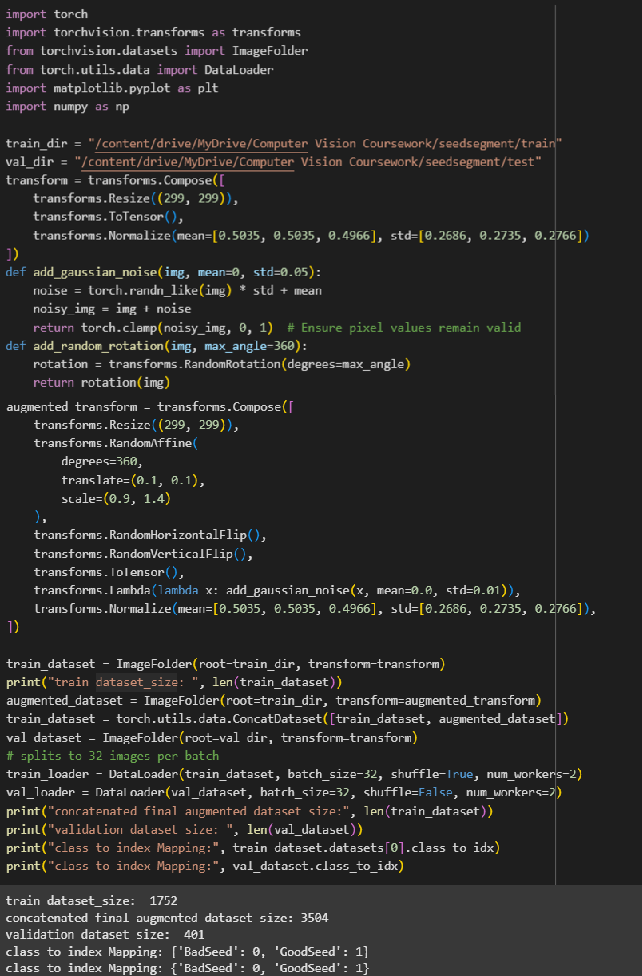

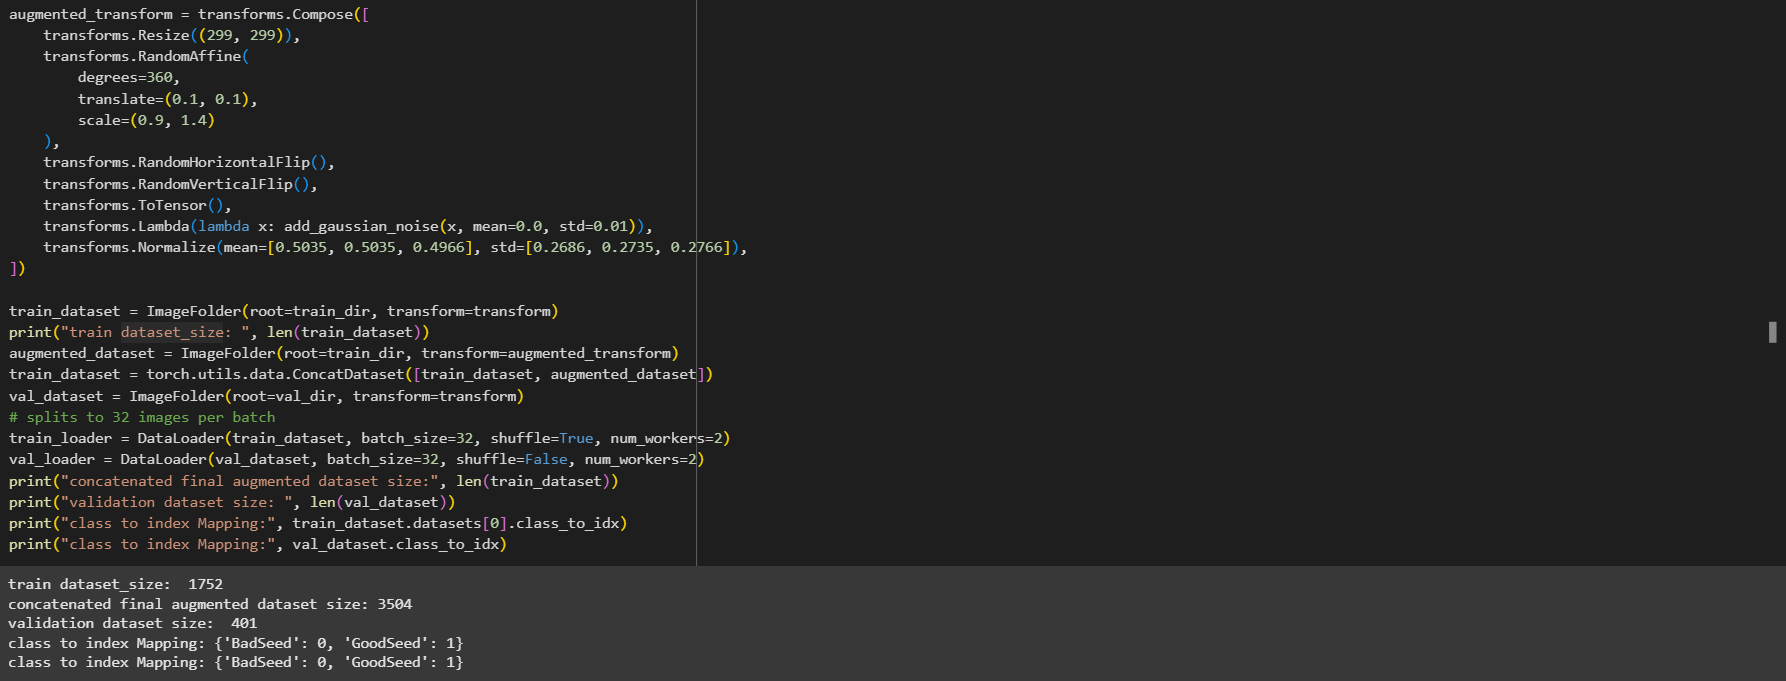

## Mounting and Necessary Imports

In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# all modules/libraries needed to run this notebook
import os
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.datasets import ImageFolder
from torchvision.models import googlenet
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import numpy as np
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import random
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from PIL import Image

## Section 4: **Dataset Analysis**
Analysing the number of images per class in each dataset split is a crucial step before training models.
- Ensures awareness of how many samples exist for each class (e.g., `GoodSeed` vs `BadSeed`).
- Identifies potential **class imbalance** issues that can negatively impact model performance.
- Helps determine whether to apply **data balancing techniques** such as oversampling the minority class, undersampling the majority class or using class weights in the loss function.
- Confirms that images are properly labeled and stored in correct directories.
- Detects any missing or unevenly distributed data early on.
- Balanced and well-understood datasets lead to models that **generalize better** to unseen data.

*The following code was implemented to analyse the nature of the dataset, i.e. class imbalance, etc.*


In [ ]:
# directories for batches 1, 2 and 3
dirs = {
    "Batch-1 (Train)": "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/train",
    "Batch-1 (Test)": "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test",
    "Batch-2 (Normal Room Light)": "/content/drive/MyDrive/Computer Vision Coursework/Test_NormalRoomLight_Seeds",
    "Batch-3 (Light Box)": "/content/drive/MyDrive/Computer Vision Coursework/Test_LightBox_Seeds"
}

# know how many images represent each class
def count_images_per_class(directory):
    class_counts = defaultdict(int)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
            class_counts[class_name] = len(images)
    return class_counts

# final results dictionary
summary = {}

for name, path in dirs.items():
    summary[name] = count_images_per_class(path)

print("\nDataset Image Count Per Class & Imbalance Ratio:\n")
print(f"{'Dataset':<35}{'GoodSeed':>12}{'BadSeed':>12}{'Imbalance Ratio':>20}")
print("-" * 80)

for dataset, counts in summary.items():
    good = counts.get('GoodSeed', 0)
    bad = counts.get('BadSeed', 0)
    # avoid divide-by-zero
    if good > 0 and bad > 0:
        imbalance_ratio = round(max(good, bad) / min(good, bad), 2)
    else:
        imbalance_ratio = "N/A"
    print(f"{dataset:<35}{good:>12}{bad:>12}{imbalance_ratio:>20}")



Dataset Image Count Per Class & Imbalance Ratio:

Dataset                                GoodSeed     BadSeed     Imbalance Ratio
--------------------------------------------------------------------------------
Batch-1 (Train)                             901         851                1.06
Batch-1 (Test)                              201         200                 1.0
Batch-2 (Normal Room Light)                 450         450                 1.0
Batch-3 (Light Box)                         605         593                1.02


### **Calculating Mean and Standard Deviation**

We calculate the mean and standard deviation of the seedsegment/train (Batch-1) dataset to normalise the images later.

In [ ]:
# first we calculate the mean and standard deviation of the training set so that we can normalise the images later before feeding into the model.
# basic transform to convert images to tensors only
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/Computer Vision Coursework/seedsegment/train", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in tqdm(loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
mean /= nb_samples
std /= nb_samples

print("Mean and Standard Deviation of the train images in Batch 1")
print("\nMean:", mean)
print("\nStd:", std)


100%|██████████| 55/55 [05:55<00:00,  6.45s/it]

Mean and Standard Deviation of the train images in Batch 1

Mean: tensor([0.5035, 0.5035, 0.4966])

Std: tensor([0.2686, 0.2735, 0.2766])


## Section 5: **Fulfilling Requirements 3, 4**


# **Requirement 3**: Perform feature extraction and/or train the feature extraction and/or classification models you chose in 3) according to the protocol in 1). [10%]
#### To fulfill this preliminary requirement, we trained \the chosen GoogLeNet model's feature extractor and classifier on `seedsegment/train`. We then used the `seedsegment/test` as the validation set and, the `Test_LightBox_Seeds` and `Test_NormalRoomLight_Seeds` served as the testing set.

The following cell processes the train and validation datasets.

In [ ]:
# set seed for reproducibility
SEED = 1000

def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

train_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/train"
val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"

# resize and normalise the image and convert to tensor
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# loading and sorting samples to ensure fixed ordering between Colab runs for reproducibility
train_dataset = ImageFolder(root=train_dir, transform=transform)
train_dataset.samples.sort()
val_dataset = ImageFolder(root=val_dir, transform=transform)
val_dataset.samples.sort()

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=g
)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Class to index Mapping (train):", train_dataset.class_to_idx)
print("Class to index Mapping (val):", val_dataset.class_to_idx)


Train dataset size: 1752
Validation dataset size: 401
Class to index Mapping (train): {'BadSeed': 0, 'GoodSeed': 1}
Class to index Mapping (val): {'BadSeed': 0, 'GoodSeed': 1}


Here, the pre-trained GoogLeNet model is initialised and the final connected layer is adapted to classify to 2 classes (BadSeed and GoodSeed)

In [ ]:
# get model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.googlenet(pretrained=True)

# modify final fully connected layer for 2 classes (good/bad seeds) and aux logit set to False by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# default loss and learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 189MB/s]


This is the `train_model` function which has a maximum number of 25 epochs and involves early stopping when it converges.

In [ ]:
# model training function for GoogLeNet
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5):
    best_val_acc = 0.0
    best_model_wts = None
    epochs_not_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.3f} - Train Accuracy: {epoch_acc:.3f}")

        # validation phase
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_acc:.3f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            epochs_not_improve = 0
        else:
            epochs_not_improve += 1
            if epochs_not_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # load best weights before returning
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model

In [ ]:
# training the model on the vanilla batch 1 train set
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5)
# save model
torch.save(model.state_dict(), "/content/drive/MyDrive/Computer Vision Coursework/models/googlenet_without_modifications.pth")

Epoch 1/25 - Train Loss: 0.280 - Train Accuracy: 0.883
Validation Accuracy: 0.758

Epoch 2/25 - Train Loss: 0.104 - Train Accuracy: 0.964
Validation Accuracy: 0.878

Epoch 3/25 - Train Loss: 0.097 - Train Accuracy: 0.963
Validation Accuracy: 0.978

Epoch 4/25 - Train Loss: 0.051 - Train Accuracy: 0.981
Validation Accuracy: 0.658

Epoch 5/25 - Train Loss: 0.073 - Train Accuracy: 0.977
Validation Accuracy: 0.958

Epoch 6/25 - Train Loss: 0.059 - Train Accuracy: 0.977
Validation Accuracy: 0.988

Epoch 7/25 - Train Loss: 0.040 - Train Accuracy: 0.985
Validation Accuracy: 0.970

Epoch 8/25 - Train Loss: 0.028 - Train Accuracy: 0.990
Validation Accuracy: 0.895

Epoch 9/25 - Train Loss: 0.024 - Train Accuracy: 0.990
Validation Accuracy: 0.935

Epoch 10/25 - Train Loss: 0.059 - Train Accuracy: 0.979
Validation Accuracy: 0.903

Epoch 11/25 - Train Loss: 0.055 - Train Accuracy: 0.984
Validation Accuracy: 0.953

Early stopping at epoch 11


In [ ]:
# function to evaluate the model on the test set (batch 2 and 3)
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, dataloader, test_dataset):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] # auc

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if isinstance(outputs, tuple):  # googlenet might return aux output
                outputs = outputs[0]

            # predicted class labels
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # get predicted probabilities for AUC (softmax output)
            probs = torch.nn.functional.softmax(outputs, dim=1)  # get probabilities
            all_probs.extend(probs.cpu().numpy()[:, 1])  # for binary classification, class 1 probabilities

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='binary')
    rec = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    auc = roc_auc_score(all_labels, all_probs)  # AUC score

    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC Score: {auc:.3f}")

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, prec, rec, f1, auc

This cell involves the evaluation of the fine-tuned GoogLeNet model on Batch 1, `seedsegment/test`.

Accuracy: 0.953
Precision: 0.917
Recall: 0.995
F1 Score: 0.955
AUC Score: 0.995


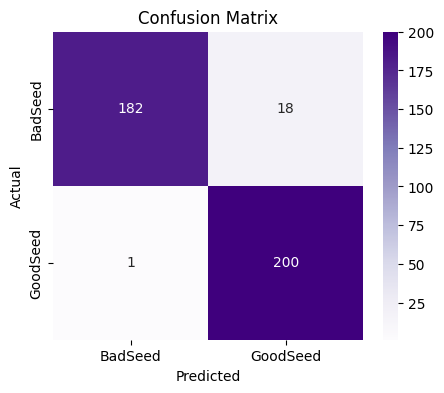

(0.9526184538653366,
 0.9174311926605505,
 0.9950248756218906,
 0.954653937947494,
 np.float64(0.9951741293532339))

In [ ]:
val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"
evaluate_model(model, val_loader, val_dataset)

The following two cells involved evaluating the model on Batch 2 and Batch 3: `Test_NormalRoomLight_Seeds` and `Test_LightBox_Seeds`

In [ ]:
# testing the trained model on batch 2 and 3
test_dir1 = "/content/drive/MyDrive/Computer Vision Coursework/Test_LightBox_Seeds"
test_dir2 = "/content/drive/MyDrive/Computer Vision Coursework/Test_NormalRoomLight_Seeds"

test_dataset1 = ImageFolder(root=test_dir1, transform=transform)
test_dataset2 = ImageFolder(root=test_dir2, transform=transform)

print("class to index Mapping (test batch 1):", test_dataset1.class_to_idx)
print("class to index Mapping (test batch 2):", test_dataset2.class_to_idx)

test_loader1 = DataLoader(test_dataset1, batch_size=32, shuffle=False, num_workers=2)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False, num_workers=2)

class to index Mapping (test batch 1): {'BadSeed': 0, 'GoodSeed': 1}
class to index Mapping (test batch 2): {'BadSeed': 0, 'GoodSeed': 1}


Evaluating on Test Set 1 (LightBox):
Accuracy: 0.732
Precision: 0.661
Recall: 0.962
F1 Score: 0.784
AUC Score: 0.829


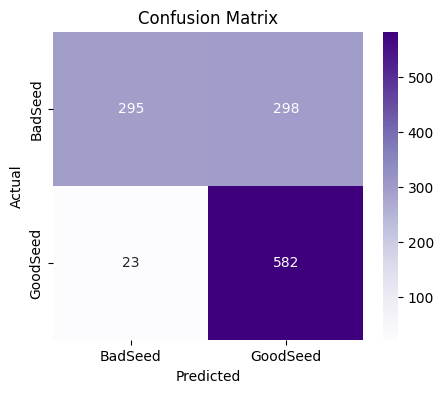

Evaluating on Test Set 2 (Normal Room Light):
Accuracy: 0.752
Precision: 0.671
Recall: 0.989
F1 Score: 0.800
AUC Score: 0.875


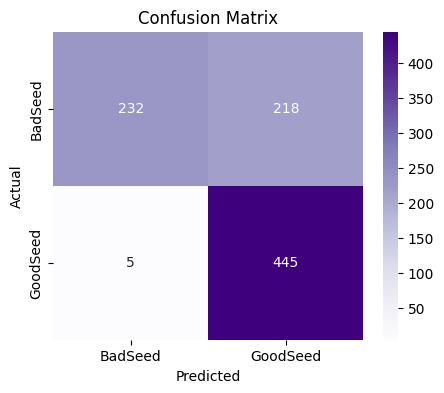

(0.7522222222222222,
 0.6711915535444947,
 0.9888888888888889,
 0.7996406109613656,
 np.float64(0.8750592592592594))

In [ ]:
# test on both datasets 299X299
print("Evaluating on Test Set 1 (LightBox):")
evaluate_model(model, test_loader1, test_dataset1)

print("Evaluating on Test Set 2 (Normal Room Light):")
evaluate_model(model, test_loader2, test_dataset2)

# **Requirement 4a**: Perform model analysis using the validation dataset in Batch-1 only and answer the following questions.
(a) For your choice of feature extraction method (if you use a deep learning
model, this would be pertaining to the feature extraction backbone)

i. How well does it handle translation changes in input images?<br>
ii. How well does it handle rotation changes in input images?<br>
iii. How well does it handle scale changes in input images?<br>
iv. How well does it handle illumination changes in input images?<br>
v. How well does it handle noise in input images?<br>
vi. How well do features capture semantic meanings of input images, i.e., are the features low-level, high-level, or a mixture of both?<br>
vii. Are the features discriminant (i.e., how well do features separate the good seeds from bad seeds)?<br>



### **Experimental Setup**
The analysis will focus on **validation dataset in Batch-1 (seedsegment/test)**, and uses **Cosine Similarity**, **Pearson Coefficient** and **Euclidean Distance** (L2 norm) to assess how consistent the model's internal representations (feature maps) are before and after applying each transformation.
- **Transformations Applied:**
  1. *Translation*: Shift image by ±10%, ±20%, ±30%
  2. *Rotation*: Rotate by ±15°, ±30°, ±45°, ±90°, ±180°, ±360°
  3. *Scaling*: Resize image by 0.8×, 1.2×, 1.5×
  4. *Noise*: σ = 0.01, 0.05, 0.1
  5. *Illumination*: brightness change to 0.5 (dimmer than normal), 1.5 (brighter than normal)

  Each transformation is applied individually to measure its isolated effect. GoogleNet retrained on the AAR dataset (from Requirement 3) will be used to compare the **original data's vs. transformed data's feature vectors**.

**Outcome**
This analysis will provide empirical insight into the **transformation invariance** of GoogleNet's 1024-dimensional feature vectors.

The following cells loads the validation dataset, feeds it into the fine-tuned GoogleNet feature extractor. The feature maps of the original images vs the augmented images (one transform at a time) are then compared.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the full model
model = googlenet(weights=None, aux_logits=False, init_weights=True)
model.fc = nn.Linear(1024, 2)  # match trained classifier structure

# load trained weights (including classifier heads)
state_dict = torch.load("/content/drive/MyDrive/Computer Vision Coursework/models/googlenet_without_modifications.pth")
model.load_state_dict(state_dict)

# remove classifier by replacing with identity (feature extractor only)
model.fc = nn.Identity()
model.to(device)

def extract_features(dataloader, model):
    features = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
    return np.array(features)


In [ ]:
def add_gaussian_noise(img, mean, std):
    noise = torch.randn_like(img) * std + mean
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0, 1)  # pixel values remain valid

def add_random_translation(img, max_shift):
    translation = transforms.RandomAffine(degrees=0, translate=(max_shift, max_shift))
    return translation(img)

def add_random_rotation(img, max_angle):
    rotation = transforms.RandomRotation(degrees=max_angle)
    return rotation(img)

def add_random_scaling(img, scale_val):
    scaling = transforms.RandomAffine(degrees=0, scale=(scale_val, scale_val))
    return scaling(img)

def add_random_illumination(img, brightness):
    illumination = transforms.ColorJitter(brightness=brightness)
    return illumination(img)

In [ ]:
# creating the different transforms to apply to the train set before training the feature extractor for googlenet
resize_shape = (299, 299)
mean = [0.5035, 0.5035, 0.4966]
std = [0.2686, 0.2735, 0.2766]

def create_transform(augmentation_func=None, **kwargs):
    aug = transforms.Lambda(lambda x: augmentation_func(x, **kwargs)) if augmentation_func else lambda x: x
    return transforms.Compose([
        transforms.Resize(resize_shape),
        transforms.ToTensor(),
        aug,
        transforms.Normalize(mean=mean, std=std)
    ])

original_transform = create_transform(None)

# brightness 0.5 & 1.5
transform_brightness0_5 = create_transform(add_random_illumination, brightness=0.5)
transform_brightness1_5 = create_transform(add_random_illumination, brightness=1.5)

# noise 0.01, 0.05, 0.1
transform_noise0_01 = create_transform(add_gaussian_noise, mean=0.0, std=0.01)
transform_noise0_05 = create_transform(add_gaussian_noise, mean=0.0, std=0.05)
transform_noise0_1  = create_transform(add_gaussian_noise, mean=0.0, std=0.1)

# scale 0.8, 1.2, 1.5
transform_scale0_8 = create_transform(add_random_scaling, scale_val=0.8)
transform_scale1_2 = create_transform(add_random_scaling, scale_val=1.2)
transform_scale1_5 = create_transform(add_random_scaling, scale_val=1.5)

# rotate 15,30,45,90,180,360
transform_rotate15   = create_transform(add_random_rotation, max_angle=15)
transform_rotate30   = create_transform(add_random_rotation, max_angle=30)
transform_rotate45   = create_transform(add_random_rotation, max_angle=45)
transform_rotate90   = create_transform(add_random_rotation, max_angle=90)
transform_rotate180  = create_transform(add_random_rotation, max_angle=180)
transform_rotate360  = create_transform(add_random_rotation, max_angle=360)

# translate 0.1, 0.2, 0.3
transform_translate0_1 = create_transform(add_random_translation, max_shift=0.1)
transform_translate0_2 = create_transform(add_random_translation, max_shift=0.2)
transform_translate0_3 = create_transform(add_random_translation, max_shift=0.3)


In [ ]:
val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"

# load the dataset and apply the transforms
val_dataset = ImageFolder(root=val_dir, transform=original_transform) # applies default resize, totensor and normalisation
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

val_dataset0 = ImageFolder(root=val_dir, transform=transform_brightness0_5)
val_loader0 = DataLoader(val_dataset0, batch_size=32, shuffle=False, num_workers=2)

val_dataset1 = ImageFolder(root=val_dir, transform=transform_brightness1_5)
val_loader1 = DataLoader(val_dataset1, batch_size=32, shuffle=False, num_workers=2)

val_dataset2 = ImageFolder(root=val_dir, transform=transform_noise0_01)
val_loader2 = DataLoader(val_dataset2, batch_size=32, shuffle=False, num_workers=2)

val_dataset3 = ImageFolder(root=val_dir, transform=transform_noise0_05)
val_loader3 = DataLoader(val_dataset3, batch_size=32, shuffle=False, num_workers=2)

val_dataset4 = ImageFolder(root=val_dir, transform=transform_noise0_1)
val_loader4 = DataLoader(val_dataset4, batch_size=32, shuffle=False, num_workers=2)

val_dataset5 = ImageFolder(root=val_dir, transform=transform_scale0_8)
val_loader5 = DataLoader(val_dataset5, batch_size=32, shuffle=False, num_workers=2)

val_dataset6 = ImageFolder(root=val_dir, transform=transform_scale1_2)
val_loader6 = DataLoader(val_dataset6, batch_size=32, shuffle=False, num_workers=2)

val_dataset7 = ImageFolder(root=val_dir, transform=transform_scale1_5)
val_loader7 = DataLoader(val_dataset7, batch_size=32, shuffle=False, num_workers=2)

val_dataset8 = ImageFolder(root=val_dir, transform=transform_rotate15)
val_loader8 = DataLoader(val_dataset8, batch_size=32, shuffle=False, num_workers=2)

val_dataset9 = ImageFolder(root=val_dir, transform=transform_rotate30)
val_loader9 = DataLoader(val_dataset9, batch_size=32, shuffle=False, num_workers=2)

val_dataset10 = ImageFolder(root=val_dir, transform=transform_rotate45)
val_loader10 = DataLoader(val_dataset10, batch_size=32, shuffle=False, num_workers=2)

val_dataset11 = ImageFolder(root=val_dir, transform=transform_rotate90)
val_loader11 = DataLoader(val_dataset11, batch_size=32, shuffle=False, num_workers=2)

val_dataset12 = ImageFolder(root=val_dir, transform=transform_rotate180)
val_loader12 = DataLoader(val_dataset12, batch_size=32, shuffle=False, num_workers=2)

val_dataset13 = ImageFolder(root=val_dir, transform=transform_rotate360)
val_loader13 = DataLoader(val_dataset13, batch_size=32, shuffle=False, num_workers=2)

val_dataset14 = ImageFolder(root=val_dir, transform=transform_translate0_1)
val_loader14 = DataLoader(val_dataset14, batch_size=32, shuffle=False, num_workers=2)

val_dataset15 = ImageFolder(root=val_dir, transform=transform_translate0_2)
val_loader15 = DataLoader(val_dataset15, batch_size=32, shuffle=False, num_workers=2)

val_dataset16 = ImageFolder(root=val_dir, transform=transform_translate0_3)
val_loader16 = DataLoader(val_dataset16, batch_size=32, shuffle=False, num_workers=2)

# extract the features from trained GoogleNet model on the transformed data
features = extract_features(val_loader, model)
features0 = extract_features(val_loader0, model)
features1 = extract_features(val_loader1, model)
features2 = extract_features(val_loader2, model)
features3 = extract_features(val_loader3, model)
features4 = extract_features(val_loader4, model)
features5 = extract_features(val_loader5, model)
features6 = extract_features(val_loader6, model)
features7 = extract_features(val_loader7, model)
features8 = extract_features(val_loader8, model)
features9 = extract_features(val_loader9, model)
features10 = extract_features(val_loader10, model)
features11 = extract_features(val_loader11, model)
features12 = extract_features(val_loader12, model)
features13 = extract_features(val_loader13, model)
features14 = extract_features(val_loader14, model)
features15 = extract_features(val_loader15, model)
features16 = extract_features(val_loader16, model)

print(features.shape)

(401, 1024)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
import numpy as np

def compare_features_all(features1, features2):
    assert features1.shape == features2.shape, "Feature arrays must be the same shape"
    cosine_sims = []
    euclidean_dists = []
    pearson_coeffs = []

    for f1, f2 in zip(features1, features2):
        cos_sim = cosine_similarity([f1], [f2])[0][0]
        cosine_sims.append(cos_sim)
        dist = euclidean(f1, f2)
        euclidean_dists.append(dist)
        r, _ = pearsonr(f1, f2)
        pearson_coeffs.append(r)

    return {
        "cosine": {
            "mean": np.mean(cosine_sims),
            "std": np.std(cosine_sims)
        },
        "euclidean": {
            "mean": np.mean(euclidean_dists),
            "std": np.std(euclidean_dists)
        },
        "pearson": {
            "mean": np.mean(pearson_coeffs),
            "std": np.std(pearson_coeffs)
        }
    }

metrics = compare_features_all(features, features) # cross checking ->
metrics0 = compare_features_all(features, features0)
metrics1 = compare_features_all(features, features1)
metrics2 = compare_features_all(features, features2)
metrics3 = compare_features_all(features, features3)
metrics4 = compare_features_all(features, features4)
metrics5 = compare_features_all(features, features5)
metrics6 = compare_features_all(features, features6)
metrics7 = compare_features_all(features, features7)
metrics8 = compare_features_all(features, features8)
metrics9 = compare_features_all(features, features9)
metrics10 = compare_features_all(features, features10)
metrics11 = compare_features_all(features, features11)
metrics12 = compare_features_all(features, features12)
metrics13 = compare_features_all(features, features13)
metrics14 = compare_features_all(features, features14)
metrics15 = compare_features_all(features, features15)
metrics16 = compare_features_all(features, features16)

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
import numpy as np

results_dict = {
    "Comparison": [
        "Original vs. Original", "Original vs. Brightness 0.5x", "Original vs. Brightness 1.5x",
        "Original vs. Gaussian Noise σ = 0.01", "Original vs. Gaussian Noise σ = 0.05", "Original vs. Gaussian Noise σ = 0.1",
        "Original vs. Scale 0.8x", "Original vs. Scale 1.2x", "Original vs. Scale 1.5x", "Original vs. Rotation 15°",
        "Original vs. Rotation 30°", "Original vs. Rotation 45°", "Original vs. Rotation 90°", "Original vs. Rotation 180°",
        "Original vs. Rotation 360°", "Original vs. Translation 10%", "Original vs. Translation 20%", "Original vs. Translation 30%"
    ],
    "Cosine Similarity (mean)": [
        round(metrics['cosine']['mean'], 2), round(metrics0['cosine']['mean'], 2), round(metrics1['cosine']['mean'], 2),
        round(metrics2['cosine']['mean'], 2), round(metrics3['cosine']['mean'], 2), round(metrics4['cosine']['mean'], 2),
        round(metrics5['cosine']['mean'], 2), round(metrics6['cosine']['mean'], 2), round(metrics7['cosine']['mean'], 2),
        round(metrics8['cosine']['mean'], 2), round(metrics9['cosine']['mean'], 2), round(metrics10['cosine']['mean'], 2),
        round(metrics11['cosine']['mean'], 2), round(metrics12['cosine']['mean'], 2), round(metrics13['cosine']['mean'], 2),
        round(metrics14['cosine']['mean'], 2), round(metrics15['cosine']['mean'], 2), round(metrics16['cosine']['mean'], 2)
    ],
    "Cosine Similarity (std)": [
        round(metrics['cosine']['std'], 2), round(metrics0['cosine']['std'], 2), round(metrics1['cosine']['std'], 2),
        round(metrics2['cosine']['std'], 2), round(metrics3['cosine']['std'], 2), round(metrics4['cosine']['std'], 2),
        round(metrics5['cosine']['std'], 2), round(metrics6['cosine']['std'], 2), round(metrics7['cosine']['std'], 2),
        round(metrics8['cosine']['std'], 2), round(metrics9['cosine']['std'], 2), round(metrics10['cosine']['std'], 2),
        round(metrics11['cosine']['std'], 2), round(metrics12['cosine']['std'], 2), round(metrics13['cosine']['std'], 2),
        round(metrics14['cosine']['std'], 2), round(metrics15['cosine']['std'], 2), round(metrics16['cosine']['std'], 2)
    ],
    "Euclidean Distance (mean)": [
        round(metrics['euclidean']['mean'], 2), round(metrics0['euclidean']['mean'], 2), round(metrics1['euclidean']['mean'], 2),
        round(metrics2['euclidean']['mean'], 2), round(metrics3['euclidean']['mean'], 2), round(metrics4['euclidean']['mean'], 2),
        round(metrics5['euclidean']['mean'], 2), round(metrics6['euclidean']['mean'], 2), round(metrics7['euclidean']['mean'], 2),
        round(metrics8['euclidean']['mean'], 2), round(metrics9['euclidean']['mean'], 2), round(metrics10['euclidean']['mean'], 2),
        round(metrics11['euclidean']['mean'], 2), round(metrics12['euclidean']['mean'], 2), round(metrics13['euclidean']['mean'], 2),
        round(metrics14['euclidean']['mean'], 2), round(metrics15['euclidean']['mean'], 2), round(metrics16['euclidean']['mean'], 2)
    ],
    "Euclidean Distance (std)": [
        round(metrics['euclidean']['std'], 2), round(metrics0['euclidean']['std'], 2), round(metrics1['euclidean']['std'], 2),
        round(metrics2['euclidean']['std'], 2), round(metrics3['euclidean']['std'], 2), round(metrics4['euclidean']['std'], 2),
        round(metrics5['euclidean']['std'], 2), round(metrics6['euclidean']['std'], 2), round(metrics7['euclidean']['std'], 2),
        round(metrics8['euclidean']['std'], 2), round(metrics9['euclidean']['std'], 2), round(metrics10['euclidean']['std'], 2),
        round(metrics11['euclidean']['std'], 2), round(metrics12['euclidean']['std'], 2), round(metrics13['euclidean']['std'], 2),
        round(metrics14['euclidean']['std'], 2), round(metrics15['euclidean']['std'], 2), round(metrics16['euclidean']['std'], 2)
    ],
    "Pearson Correlation (mean)": [
        round(metrics['pearson']['mean'], 2), round(metrics0['pearson']['mean'], 2), round(metrics1['pearson']['mean'], 2),
        round(metrics2['pearson']['mean'], 2), round(metrics3['pearson']['mean'], 2), round(metrics4['pearson']['mean'], 2),
        round(metrics5['pearson']['mean'], 2), round(metrics6['pearson']['mean'], 2), round(metrics7['pearson']['mean'], 2),
        round(metrics8['pearson']['mean'], 2), round(metrics9['pearson']['mean'], 2), round(metrics10['pearson']['mean'], 2),
        round(metrics11['pearson']['mean'], 2), round(metrics12['pearson']['mean'], 2), round(metrics13['pearson']['mean'], 2),
        round(metrics14['pearson']['mean'], 2), round(metrics15['pearson']['mean'], 2), round(metrics16['pearson']['mean'], 2)
    ],
    "Pearson Correlation (std)": [
        round(metrics['pearson']['std'], 2), round(metrics0['pearson']['std'], 2), round(metrics1['pearson']['std'], 2),
        round(metrics2['pearson']['std'], 2), round(metrics3['pearson']['std'], 2), round(metrics4['pearson']['std'], 2),
        round(metrics5['pearson']['std'], 2), round(metrics6['pearson']['std'], 2), round(metrics7['pearson']['std'], 2),
        round(metrics8['pearson']['std'], 2), round(metrics9['pearson']['std'], 2), round(metrics10['pearson']['std'], 2),
        round(metrics11['pearson']['std'], 2), round(metrics12['pearson']['std'], 2), round(metrics13['pearson']['std'], 2),
        round(metrics14['pearson']['std'], 2), round(metrics15['pearson']['std'], 2), round(metrics16['pearson']['std'], 2)
    ]
}

df = pd.DataFrame(results_dict)

df.to_csv("/content/drive/MyDrive/Computer Vision Coursework/results/feature_comparison_results.csv", index=False)

print("Results have been exported to 'feature_comparison_results.csv'")


Results have been exported to 'feature_comparison_results.csv'


In [ ]:
# visualise the results

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Computer Vision Coursework/results/feature_comparison_results.csv")
df

del model
torch.cuda.empty_cache()

### The following cells show the representation of the features extracted to support the following questions in requirement 4a: <br>
vi. How well do features capture semantic meanings of input images, i.e., are the features low-level, high-level, or a mixture of both?<br>
vii. Are the features discriminant (i.e., how well do features separate the
good seeds from bad seeds)?<br>


In [ ]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

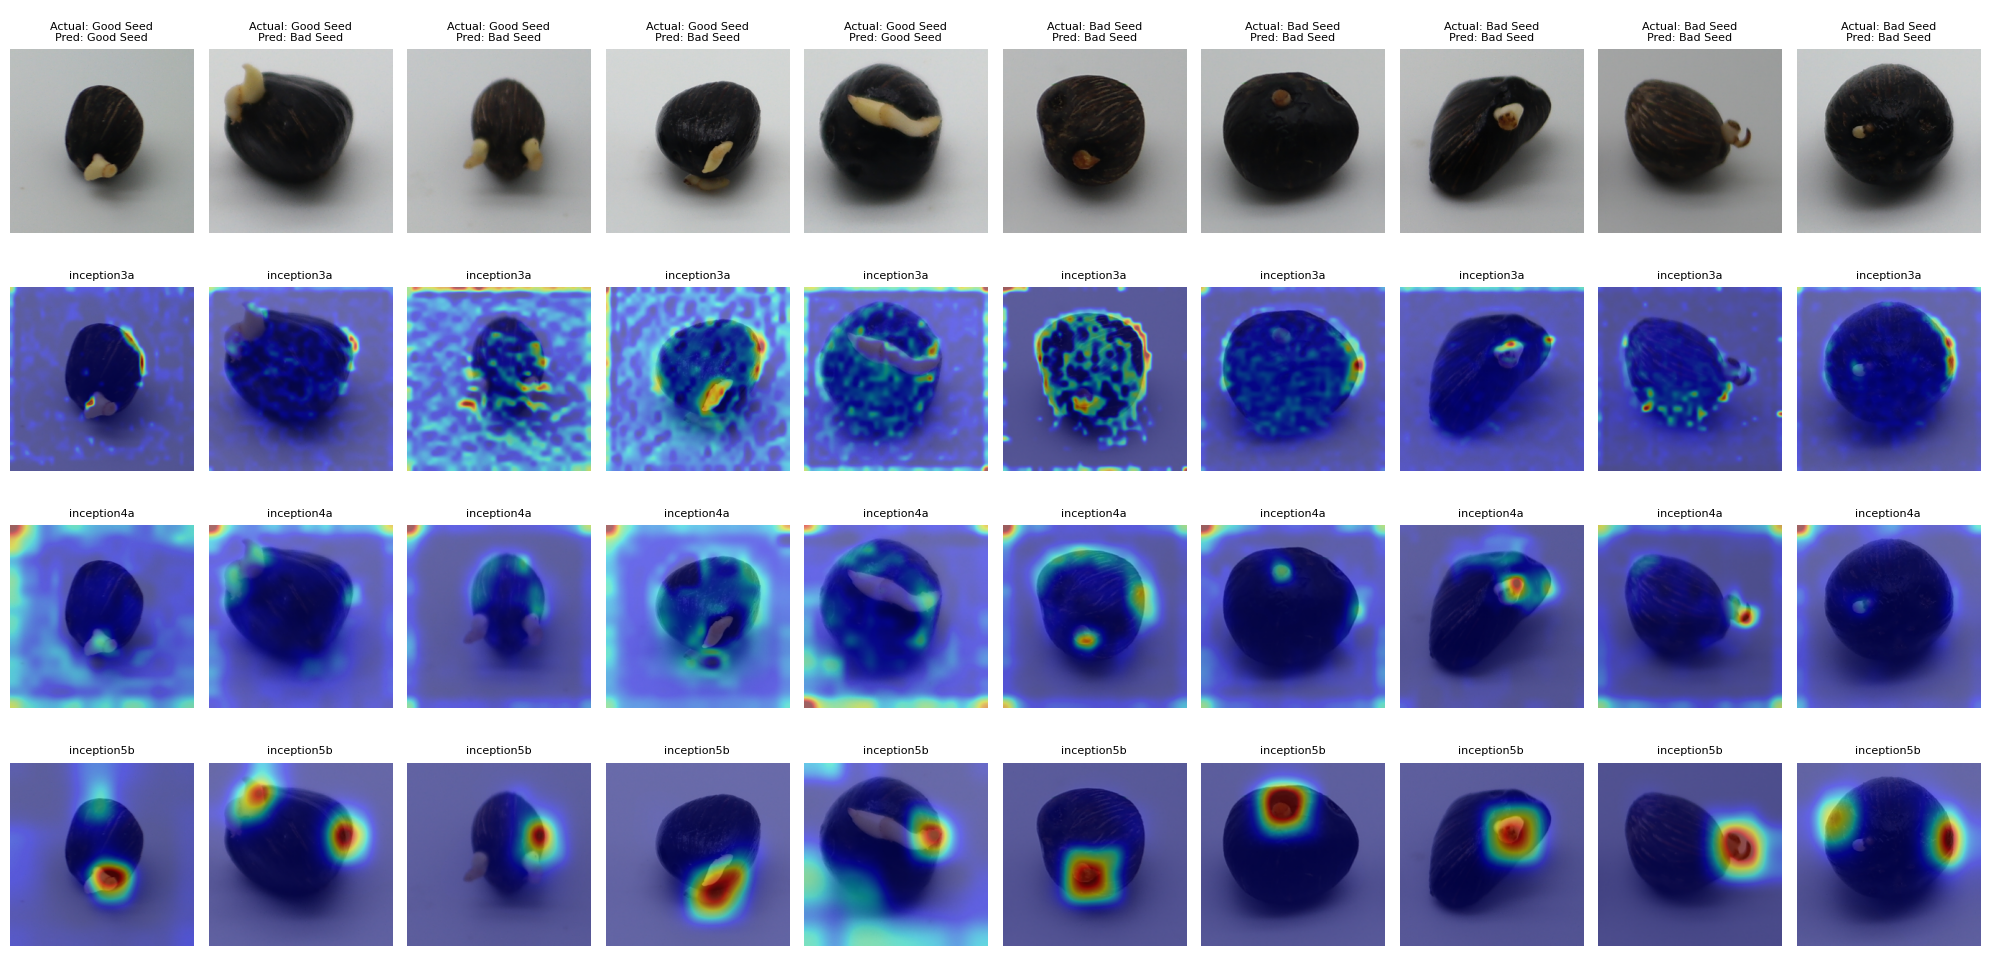

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import googlenet
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = googlenet(weights=None, aux_logits=False, init_weights=True)
model.fc = nn.Linear(1024, 2)
state_dict = torch.load("/content/drive/MyDrive/Computer Vision Coursework/models/googlenet_without_modifications.pth")
model.load_state_dict(state_dict)
model.to(device).eval()

original_transform = create_transform()

def generate_cam(image_path, target_layer):
    img = Image.open(image_path).convert("RGB")
    input_tensor = original_transform(img).unsqueeze(0).to(device)
    cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)
    out = model(input_tensor)
    class_idx = out.squeeze().argmax().item()
    predicted_label = "Bad Seed" if class_idx == 0 else "Good Seed"
    activation_map = cam_extractor(class_idx, out)[0].squeeze().cpu().numpy()
    heatmap_img = Image.fromarray(activation_map, mode='F')
    result = overlay_mask(img, heatmap_img, alpha=0.5)
    return result, predicted_label

image_info = [
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest9.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest177.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest18.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest195.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/GoodSeed/goodtest74.png", "Good Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest19.png", "Bad Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest13.png", "Bad Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest139.png", "Bad Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest119.png", "Bad Seed"),
    ("/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test/BadSeed/badtest102.png", "Bad Seed")
]

layers_to_check = [
    ("inception3a", model.inception3a),
    ("inception4a", model.inception4a),
    ("inception5b", model.inception5b)
]

fig, axes = plt.subplots(nrows=len(layers_to_check) + 1, ncols=len(image_info), figsize=(20, 10))


axes = axes.flatten()

for j, (path, actual) in enumerate(image_info):
    img = Image.open(path).convert("RGB")
    input_tensor = original_transform(img).unsqueeze(0).to(device)
    out = model(input_tensor)
    class_idx = out.squeeze().argmax().item()
    predicted_label = "Bad Seed" if class_idx == 0 else "Good Seed"

    ax = axes[j]
    ax.imshow(img)
    ax.set_title(f"\nActual: {actual}\nPred: {predicted_label}", fontsize=8)
    ax.axis('off')

    for i, (layer_name, target_layer) in enumerate(layers_to_check):
        result, _ = generate_cam(path, target_layer)
        ax = axes[(i + 1) * len(image_info) + j]
        ax.imshow(result)
        ax.set_title(f"{layer_name}", fontsize=8)
        ax.axis('off')


plt.tight_layout(h_pad = 0.1)
plt.subplots_adjust(hspace=0.01)
plt.show()


# **Requirement 4b**: Perform model analysis using the validation dataset in Batch-1 only and answer the following questions.
For your choice of classification method (if you use a deep learning
model, this would be pertaining to the classifier part of the model):<br>
i. How do translation changes in input images affect the classification
performance? <br>
ii. How do rotation changes in input images affect the classification
performance? <br>
iii. How do scale changes in input images affect the classification
performance? <br>
iv. How do illumination changes in input images affect the classification
performance? <br>
v. How do noise in input images affect the classification performance? <br>
vi. How do different levels of semantic feature representation affect the
classification performance? <br>

### **Experimental Setup**
The analysis will focus on **validation dataset in Batch-1 (seedsegment/test)**, and uses **Accuracy**, **Precision**, **Recall**, **F1 Score** and **AUC Score** to assess how consistent the model's classification performance.
- **Transformations Applied:**
  1. *Translation*: Shift image by ±10%, ±20%, ±30%
  2. *Rotation*: Rotate by ±15°, ±30°, ±45°, ±90°, ±180°, ±360°
  3. *Scaling*: Resize image by 0.8×, 1.2×, 1.5×
  4. *Noise*: σ = 0.01, 0.05, 0.1
  5. *Illumination*: brightness change to 0.5 (dimmer than normal), 1.5 (brighter than normal)

  Each transformation is applied individually to measure its isolated effect. GoogleNet retrained on the AAR dataset (from Requirement 3) will be used to compare the **original data's vs. transformed data's classification**.

**Outcome**
This analysis will provide empirical insight into the **classification robustness** of GoogleNet when subjected to image transformations.

The following cells loads the validation dataset, feeds it into the fine-tuned GoogleNet model. Then, the metrics mentioned above and relevent confusion matrices are outputted.

In [ ]:
del model #delete the feature extractor model loaded earlier
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the model weights while ignoring the missing/mismatched layers
model = googlenet(weights=None, aux_logits=False, num_classes=2)
model.fc = nn.Linear(1024, 2)
model.load_state_dict(torch.load("/content/drive/MyDrive/Computer Vision Coursework/models/googlenet_without_modifications.pth"), strict=False)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Evaluating on validation set (Brightness=0.5):
Accuracy: 0.880
Precision: 0.958
Recall: 0.796
F1 Score: 0.870
AUC Score: 0.969


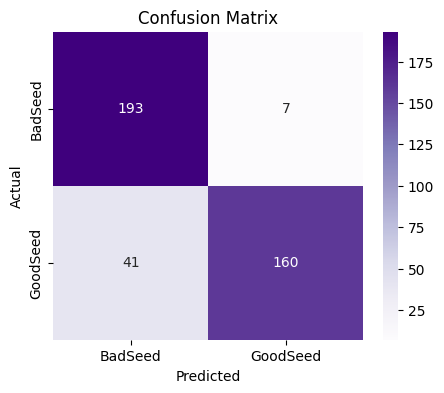

Evaluating on validation set (Brightness=1.5):
Accuracy: 0.818
Precision: 0.900
Recall: 0.716
F1 Score: 0.798
AUC Score: 0.928


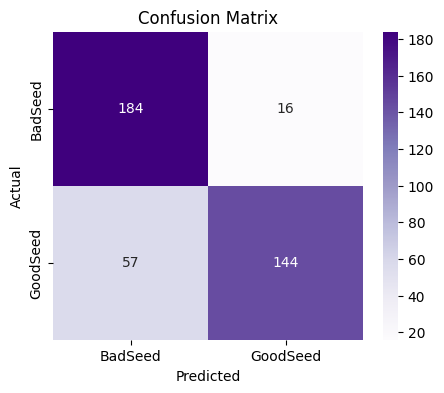

Evaluating on validation set (Noise=0.01):
Accuracy: 0.855
Precision: 0.993
Recall: 0.716
F1 Score: 0.832
AUC Score: 0.990


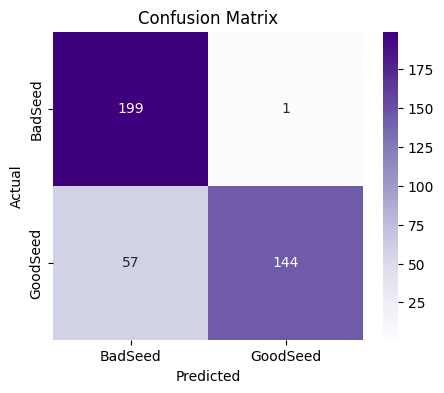

Evaluating on validation set (Noise=0.05):
Accuracy: 0.511
Precision: 1.000
Recall: 0.025
F1 Score: 0.049
AUC Score: 0.935


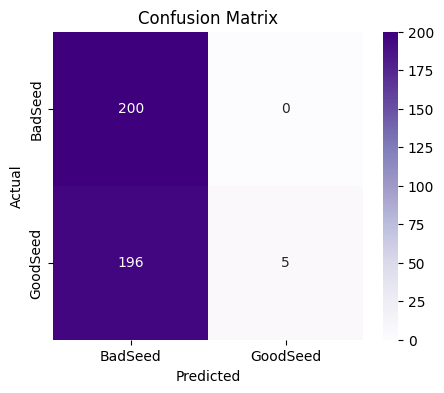

Evaluating on validation set (Noise=0.1):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.499
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
AUC Score: 0.735


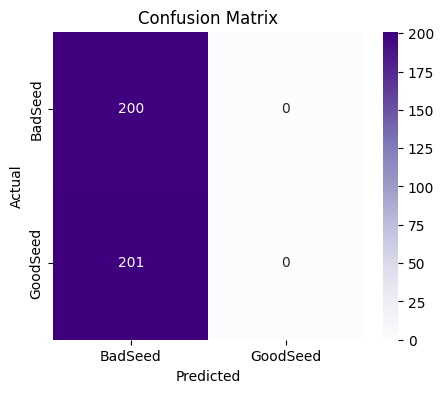

Evaluating on validation set (Scale=0.8):
Accuracy: 0.953
Precision: 0.969
Recall: 0.935
F1 Score: 0.952
AUC Score: 0.990


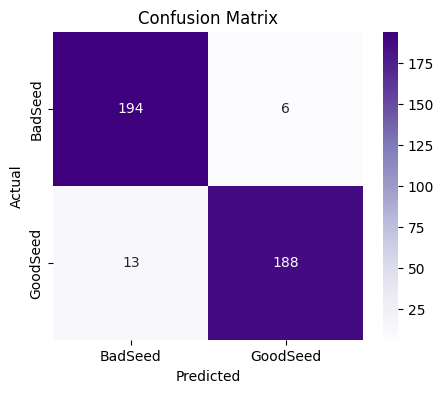

Evaluating on validation set (Scale=1.2):
Accuracy: 0.853
Precision: 0.993
Recall: 0.711
F1 Score: 0.829
AUC Score: 0.991


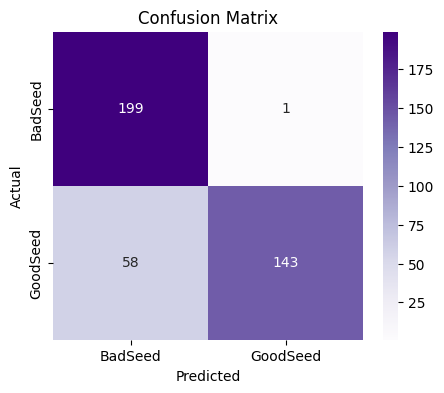

Evaluating on validation set (Scale=1.5):
Accuracy: 0.838
Precision: 0.986
Recall: 0.687
F1 Score: 0.809
AUC Score: 0.984


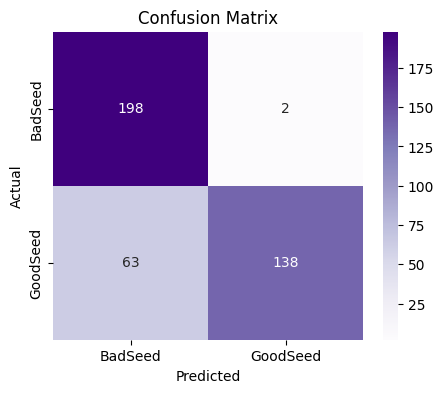

Evaluating on validation set (Rotate=15):
Accuracy: 0.928
Precision: 0.989
Recall: 0.866
F1 Score: 0.923
AUC Score: 0.991


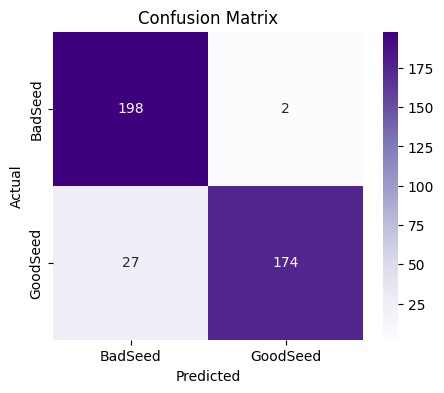

Evaluating on validation set (Rotate=30):
Accuracy: 0.938
Precision: 0.978
Recall: 0.896
F1 Score: 0.935
AUC Score: 0.993


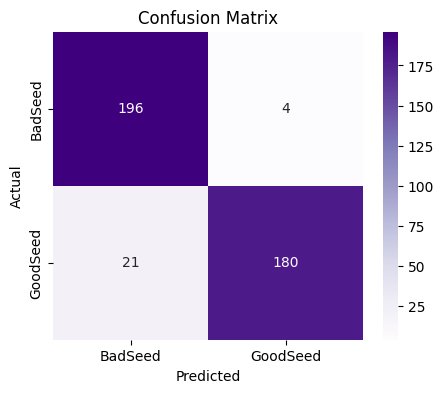

Evaluating on validation set (Rotate=45):
Accuracy: 0.950
Precision: 0.974
Recall: 0.925
F1 Score: 0.949
AUC Score: 0.991


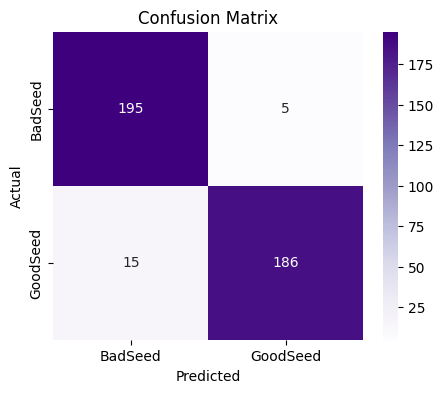

Evaluating on validation set (Rotate=90):
Accuracy: 0.955
Precision: 0.984
Recall: 0.925
F1 Score: 0.954
AUC Score: 0.994


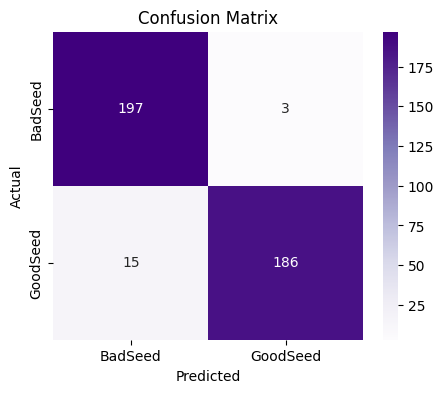

Evaluating on validation set (Rotate=180):
Accuracy: 0.948
Precision: 0.974
Recall: 0.920
F1 Score: 0.946
AUC Score: 0.985


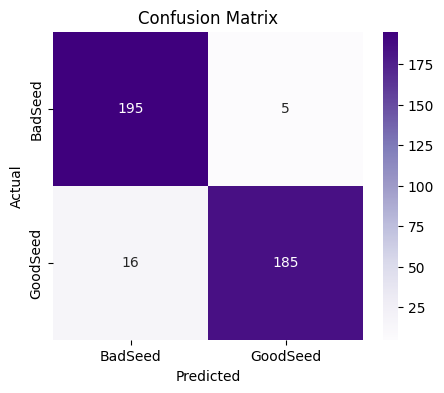

Evaluating on validation set (Rotate=360):
Accuracy: 0.920
Precision: 0.952
Recall: 0.886
F1 Score: 0.918
AUC Score: 0.986


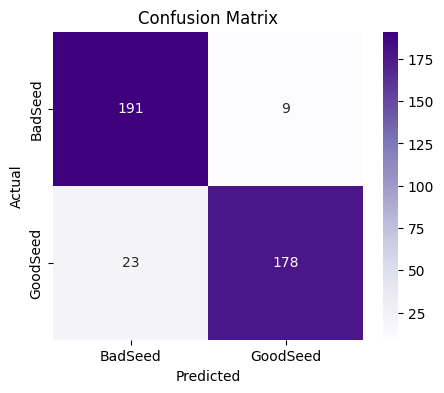

Evaluating on validation set (Translate=0.1):
Accuracy: 0.930
Precision: 0.994
Recall: 0.866
F1 Score: 0.926
AUC Score: 0.993


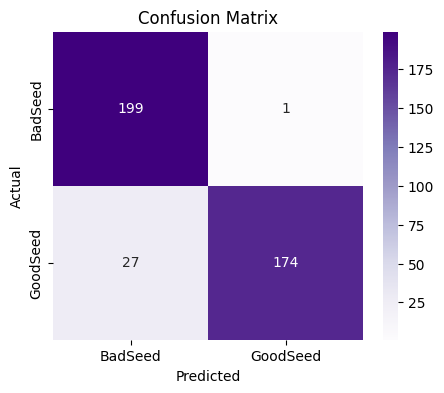

Evaluating on validation set (Translate=0.2):
Accuracy: 0.935
Precision: 0.983
Recall: 0.886
F1 Score: 0.932
AUC Score: 0.990


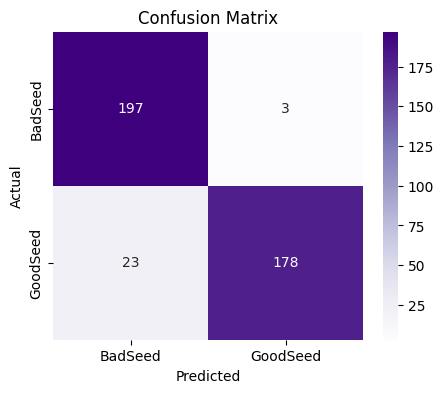

Evaluating on validation set (Translate=0.3):
Accuracy: 0.945
Precision: 0.979
Recall: 0.910
F1 Score: 0.943
AUC Score: 0.989


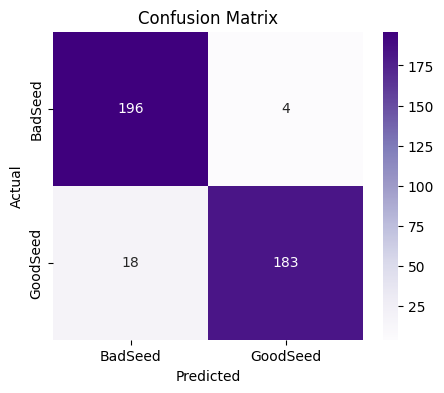

Evaluation results saved to CSV file.


In [ ]:
val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"

# Define the transformations and corresponding labels
transformations = [
    (transform_brightness0_5, "Brightness=0.5"),
    (transform_brightness1_5, "Brightness=1.5"),
    (transform_noise0_01, "Noise=0.01"),
    (transform_noise0_05, "Noise=0.05"),
    (transform_noise0_1, "Noise=0.1"),
    (transform_scale0_8, "Scale=0.8"),
    (transform_scale1_2, "Scale=1.2"),
    (transform_scale1_5, "Scale=1.5"),
    (transform_rotate15, "Rotate=15"),
    (transform_rotate30, "Rotate=30"),
    (transform_rotate45, "Rotate=45"),
    (transform_rotate90, "Rotate=90"),
    (transform_rotate180, "Rotate=180"),
    (transform_rotate360, "Rotate=360"),
    (transform_translate0_1, "Translate=0.1"),
    (transform_translate0_2, "Translate=0.2"),
    (transform_translate0_3, "Translate=0.3")
]

import pandas as pd

metrics_dict = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
}

for transform, label in transformations:
    val_dataset = ImageFolder(root=val_dir, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    print(f"Evaluating on validation set ({label}):")

    acc, prec, rec, f1, auc = evaluate_model(model, val_loader, val_dataset)
    metrics_dict[label] = [acc, prec, rec, f1, auc]

metrics_df = pd.DataFrame(metrics_dict)

metrics_df.to_csv("/content/drive/MyDrive/Computer Vision Coursework/results/evaluation_results_original.csv", index=False)

print("Evaluation results saved to CSV file.")


## Section 6: **Features Visualisation Across Different Layers**
The following cell outputs the representation of the features at different layers of the model i.e. *conv1, inception3a, inception3b, inception4a, inception4c, inception5a, inception5b, avgpool*. This visualisation is used to discuss the results of Requirement 4.

Please note: This cell may crash while running due to unavailable RAM, simply rerun this cell after connecting to runtime.

Extracting Features: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


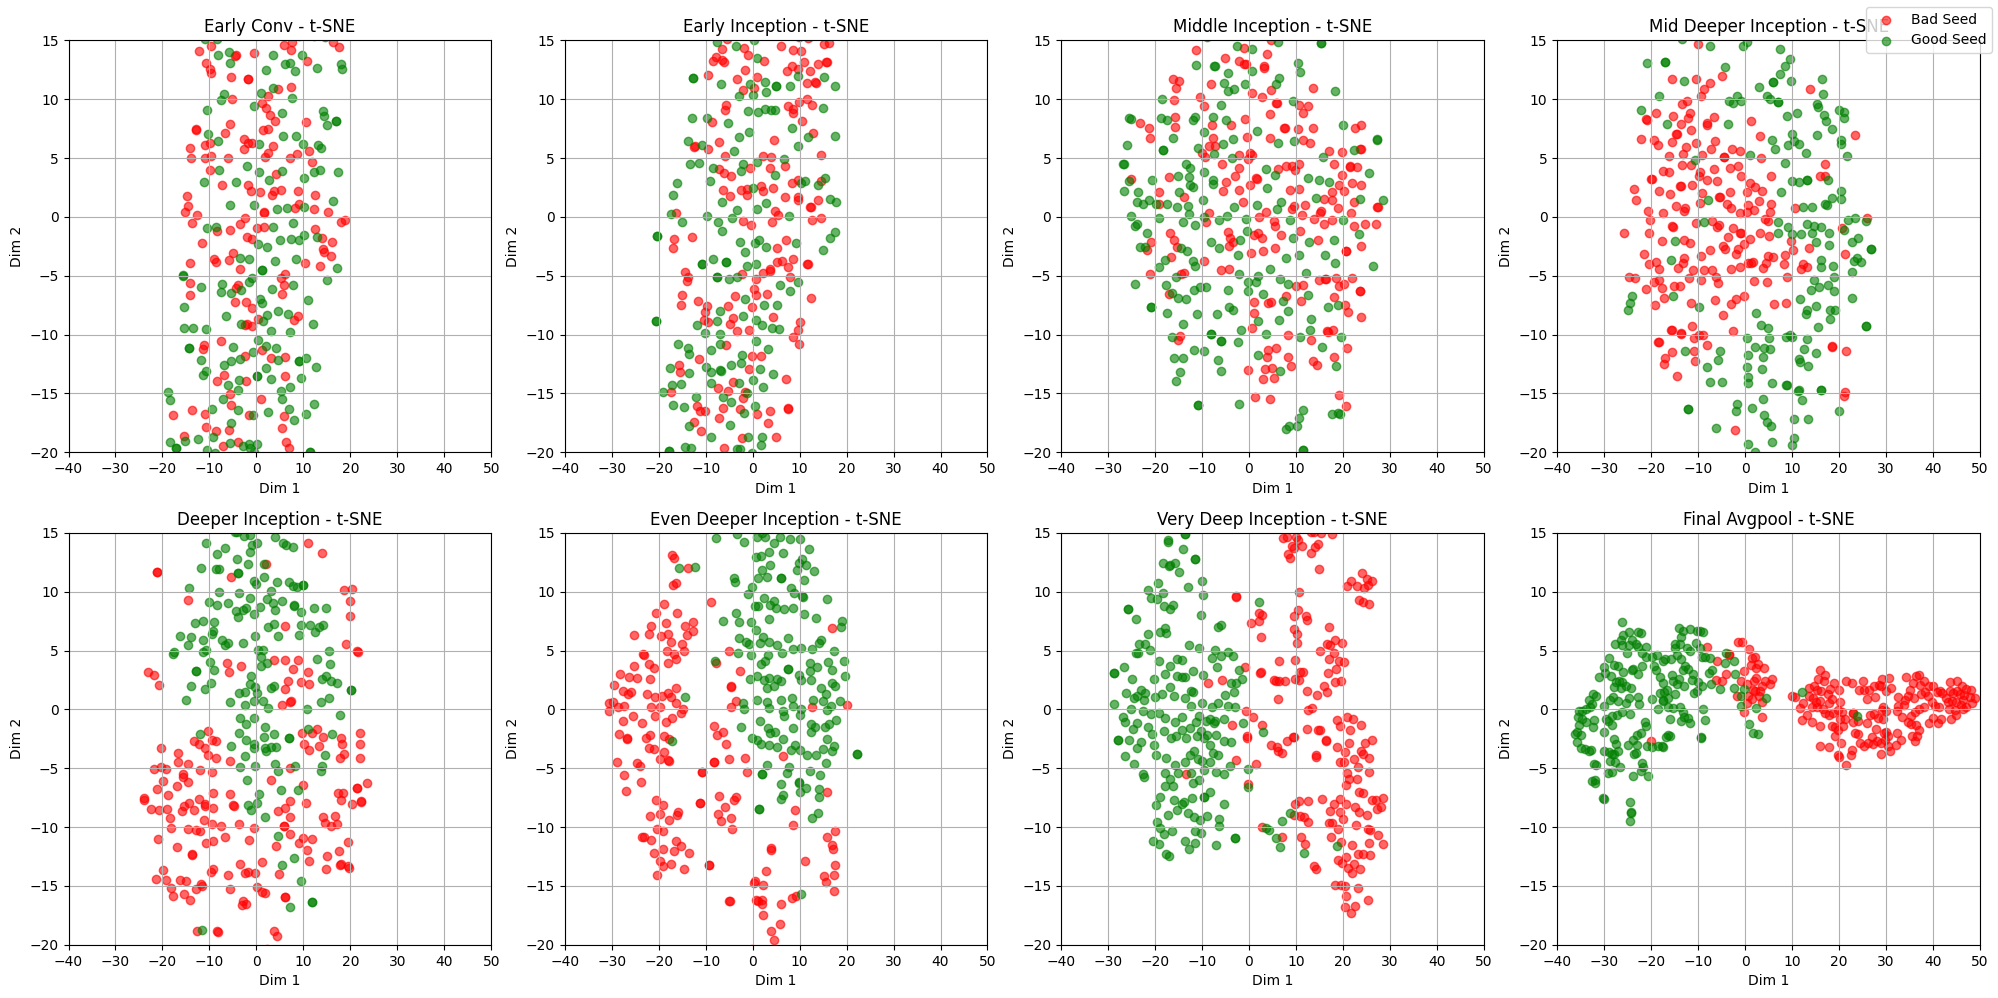

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision.datasets import ImageFolder
from torchvision.models import googlenet

#to store the feature maps
feature_maps = {}

def get_activation(name):
    def hook(model, input, output):
        feature_maps[name] = output.detach()
    return hook

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = googlenet(weights=None, aux_logits=False, init_weights=True)
model.fc = nn.Linear(1024, 2)  # modify classifier for 2 output classes
state_dict = torch.load("/content/drive/MyDrive/Computer Vision Coursework/models/googlenet_without_modifications.pth")
model.load_state_dict(state_dict)

#select layers to hook
layers_to_hook = {
    'early_conv': model.conv1,
    'early_inception': model.inception3a,
    'middle_inception': model.inception3b,
    'mid_deeper_inception': model.inception4a,
    'deeper_inception': model.inception4c,
    'even_deeper_inception': model.inception5a,
    'very_deep_inception': model.inception5b,
    'final_avgpool': model.avgpool,
}

#attach hooks
for name, layer in layers_to_hook.items():
    layer.register_forward_hook(get_activation(name))

#remove the final classification layer for feature extraction
model.fc = nn.Identity()
model.to(device).eval()

#extract features from validation set

val_dir = "/content/drive/MyDrive/Computer Vision Coursework/seedsegment/test"

mean = [0.5035, 0.5035, 0.4966]
std = [0.2686, 0.2735, 0.2766]

original_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_dataset = ImageFolder(root=val_dir, transform=original_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

all_features = {name: [] for name in layers_to_hook.keys()}
all_labels = []

#disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Extracting Features"):
        images = images.to(device)
        labels = labels.to(device)

        #forward pass
        outputs = model(images)

        #store features from hooked layers to featuremaps dict
        for name in layers_to_hook.keys():
            feats = feature_maps[name]
            feats = feats.view(feats.size(0), -1)
            all_features[name].append(feats.cpu())

        all_labels.append(labels.cpu())

#concatenate across batches
for name in all_features.keys():
    all_features[name] = torch.cat(all_features[name], dim=0)
all_labels = torch.cat(all_labels, dim=0)

#run t-SNE and plot

def plot_tsne(features, labels, title, ax):
    features = features.numpy()
    labels = labels.numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)

    good_indices = labels == 1
    bad_indices = labels == 0

    ax.scatter(features_2d[bad_indices, 0], features_2d[bad_indices, 1],
               c='red', label='Bad Seed', alpha=0.6)
    ax.scatter(features_2d[good_indices, 0], features_2d[good_indices, 1],
               c='green', label='Good Seed', alpha=0.6)
    ax.set_title(f"{title} - t-SNE")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.grid(True)
    ax.set_xlim(-40, 50)
    ax.set_ylim(-20, 15)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, features) in enumerate(all_features.items()):
    plot_tsne(features, all_labels, title=name.replace("_", " ").title(), ax=axes[idx])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()
